
# Corn Leaf Disease Detection with Enhanced KNN (EKNN)

Notebook ini mengimplementasikan tahapan utama dari jurnal:

> **"Corn leaf image classification based on machine learning techniques for accurate leaf disease detection" (IJECE, 2022)**

Pipeline:

1. Pre-processing (normalisasi, grayscale, reduksi noise)
2. Segmentasi dengan **Otsu Thresholding**
3. Ekstraksi fitur (Fine, Coarse, DOR)
4. Klasifikasi dengan Enhanced K-Nearest Neighbour (EKNN)
5. Evaluasi: Confusion Matrix, Classification Report, ROC multi-kelas
6. Visualisasi: Before–After preprocessing & segmentasi per kelas.


In [1]:

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

print("Libraries loaded.")


Libraries loaded.


In [2]:
# Setelah unzip

# Pertama, mari kita periksa struktur internal archive.zip
print("Listing contents of archive.zip:")
!unzip -l /content/archive.zip
print("\n")

# Lakukan unzip
print("Unzipping archive.zip to /content/...")
!unzip /content/archive.zip -d /content/
print("\n")

# Periksa apa yang sebenarnya ada di direktori /content/ setelah unzip
print("Listing contents of /content/ after unzip:")
!ls -R /content/
print("\n")

# Pindahkan folder utama dataset ke lokasi dataset final
# Asumsi: setelah unzip, ada folder 'data jagung' di dalam '/content/' yang berisi 'train' dan 'validation'.
# Kita akan memindahkan seluruh folder 'data jagung' ke dalam '/content/dataset/'
# Sehingga struktur menjadi: /content/dataset/data jagung/train dan /content/dataset/data jagung/validation

# Buat direktori target jika belum ada
!mkdir -p "/content/dataset"

SOURCE_DATA_DIR = "/content/data jagung"

if os.path.exists(SOURCE_DATA_DIR):
    print(f"Moving '{SOURCE_DATA_DIR}' to '/content/dataset/'...")
    !mv "{SOURCE_DATA_DIR}" "/content/dataset/"
    print("Move complete.")
else:
    print(f"WARNING: Source directory '{SOURCE_DATA_DIR}' not found. Please check 'ls -R /content/' output and adjust the 'SOURCE_DATA_DIR' variable accordingly.")
    print("The mv command for dataset setup might have failed.")


# Set direktori dataset utama. Kini dataset berada di /content/dataset/data jagung
BASE_DIR = "/content/dataset/data jagung"

CLASS_MAP = {
    "daun sehat": "HL",
    "bercak daun": "LSG",
    "hawar daun": "NLB",
    "karat daun": "RS"
}

print("Base directory for dataset processing:", BASE_DIR)
print("Kelas yang diharapkan:", CLASS_MAP)


Listing contents of archive.zip:
Archive:  /content/archive.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-11-30 17:22   data jagung/data jagung train/
        0  2025-11-30 17:26   data jagung/data jagung train/daun rusak/
    27882  2025-11-30 17:26   data jagung/data jagung train/daun rusak/(1)_result.jpg
    29394  2025-11-30 17:26   data jagung/data jagung train/daun rusak/(10)_result.jpg
    23577  2025-11-30 17:22   data jagung/data jagung train/daun rusak/(11)_result.jpg
    24150  2025-11-30 17:22   data jagung/data jagung train/daun rusak/(12)_result.jpg
    24634  2025-11-30 17:22   data jagung/data jagung train/daun rusak/(13)_result.jpg
    24713  2025-11-30 17:22   data jagung/data jagung train/daun rusak/(14)_result.jpg
    24258  2025-11-30 17:22   data jagung/data jagung train/daun rusak/(15)_result.jpg
    24486  2025-11-30 17:22   data jagung/data jagung train/daun rusak/(16)_result.jpg
    24462  2025-11-30 17:22   data jag

In [3]:

# ===================================================================================
# PRE-PROCESSING & SEGMENTASI
# ===================================================================================

def preprocess_image(img, target_size=(256, 256)):
    """
    Preprocessing citra daun jagung.

    Tahapan:
    1. Resize ke ukuran target (default 256x256, sejalan dengan PlantVillage).
    2. BGR (OpenCV) -> RGB.
    3. Normalisasi piksel ke [0, 1].
    4. Konversi ke grayscale.
    """
    img_resized = cv2.resize(img, target_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_rgb_norm = img_rgb.astype("float32") / 255.0
    gray = cv2.cvtColor((img_rgb_norm * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
    return img_rgb_norm, gray


def segment_otsu(gray):
    """
    Segmentasi Otsu berbasis intensitas.

    1. Gaussian blur untuk mereduksi noise.
    2. Thresholding Otsu -> citra biner.
    """
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, otsu_binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_binary


In [4]:

# ===================================================================================
# EKSTRAKSI FITUR: FINE, COARSE, DOR
# ===================================================================================

def extract_fine_features(gray, radius=1, neighbors=8, step=2):
    """
    Fine Features berbasis pola tekstur lokal (mirip LBP rotation-invariant).

    - Untuk setiap piksel pusat (sampling step):
      * Bandingkan intensitas tetangga di lingkaran radius tertentu.
      * Bentuk kode biner (>= center -> 1, < center -> 0).
      * Jadikan rotation-invariant dengan mencari rotasi minimum.
    - Bungkus dalam bentuk histogram sehingga dimensi tetap.
    """
    h, w = gray.shape
    codes = []

    for y in range(radius, h - radius, step):
        for x in range(radius, w - radius, step):
            center = gray[y, x]
            binary = []
            for n in range(neighbors):
                theta = 2.0 * np.pi * n / neighbors
                yy = int(round(y + radius * np.sin(theta)))
                xx = int(round(x + radius * np.cos(theta)))
                binary.append(1 if gray[yy, xx] >= center else 0)

            rotations = [
                int("".join(map(str, binary[i:] + binary[:i])), 2)
                for i in range(neighbors)
            ]
            ri_code = min(rotations)
            codes.append(ri_code)

    hist, _ = np.histogram(codes, bins=256, range=(0, 256))
    hist = hist.astype("float32")
    if hist.sum() > 0:
        hist /= hist.sum()
    return hist


def extract_coarse_features(gray, num_bins=32):
    """
    Coarse Features berdasarkan magnitude gradien (struktur global).

    - Hitung gradien x dan y (Sobel).
    - Hitung magnitude gradien.
    - Buat histogram magnitude sebagai fitur.
    """
    sobelx = cv2.Sobel(gray.astype("float32"), cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray.astype("float32"), cv2.CV_32F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    hist, _ = np.histogram(magnitude, bins=num_bins, range=(0, magnitude.max() + 1e-6))
    hist = hist.astype("float32")
    if hist.sum() > 0:
        hist /= hist.sum()
    return hist


def extract_dor_features(gray, window_size=5):
    """
    Confined Intensity Directional Order Relation (DOR) sederhana.

    - Ambil jendela lokal (window_size x window_size) di sekitar tiap piksel.
    - Hitung selisih absolut intensitas tetangga terhadap pusat.
    - Tetangga dengan selisih terbesar => dominant direction.
    - Histogram frekuensi dominant direction menjadi fitur.
    """
    assert window_size % 2 == 1, "window_size harus ganjil"

    pad = window_size // 2
    padded = np.pad(gray.astype("float32"), pad, mode="reflect")
    h, w = gray.shape
    dom_idx = []

    for y in range(pad, h + pad):
        for x in range(pad, w + pad):
            region = padded[y-pad:y+pad+1, x-pad:x+pad+1]
            center = padded[y, x]
            diffs = np.abs(region - center).flatten()
            idx = int(np.argmax(diffs))
            dom_idx.append(idx)

    num_pos = window_size * window_size
    hist, _ = np.histogram(dom_idx, bins=num_pos, range=(0, num_pos))
    hist = hist.astype("float32")
    if hist.sum() > 0:
        hist /= hist.sum()
    return hist


def extract_all_features(gray):
    """
    Wrapper untuk menggabungkan:
    - Fine features
    - Coarse features
    - DOR features

    Hasil akhirnya adalah satu vektor fitur berdimensi tetap.
    """
    fine = extract_fine_features(gray)
    coarse = extract_coarse_features(gray)
    dor = extract_dor_features(gray)
    feat_vec = np.concatenate([fine, coarse, dor]).astype("float32")
    return feat_vec


In [5]:

# ===================================================================================
# LOAD DATASET & GENERATE FITUR
# ===================================================================================

def load_dataset(base_dir, class_map, max_images_per_class=None):
    """
    Memuat citra daun jagung dari struktur folder dan menghasilkan fitur.

    - Loop setiap folder kelas sesuai class_map.
    - Preprocessing (resize, RGB, normalisasi, grayscale).
    - Segmentasi Otsu (untuk visualisasi / konsistensi pipeline).
    - Ekstraksi fitur (fine + coarse + DOR).

    Parameters
    ----------
    base_dir : str
        Folder utama dataset.
    class_map : dict
        Mapping nama folder -> label (string).
    max_images_per_class : int or None
        Batas jumlah citra per kelas (opsional).

    Returns
    -------
    X : np.ndarray
        Matriks fitur (num_samples x num_features).
    y : np.ndarray
        Label kelas untuk setiap sampel.
    paths : list of str
        Path citra yang digunakan.
    """
    X_list = []
    y_list = []
    paths = []

    for folder_name, label in class_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            print(f"[PERINGATAN] Folder tidak ditemukan: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        files = sorted(files)
        if max_images_per_class is not None:
            files = files[:max_images_per_class]

        print(f"Memproses kelas '{folder_name}' ({label}), jumlah citra: {len(files)}")

        for fname in files:
            fpath = os.path.join(folder_path, fname)
            img = cv2.imread(fpath)
            if img is None:
                print("  [SKIP] Gagal baca citra:", fpath)
                continue

            rgb_norm, gray = preprocess_image(img)
            _ = segment_otsu(gray)  # tidak digunakan langsung untuk fitur di sini

            feat = extract_all_features(gray)
            X_list.append(feat)
            y_list.append(label)
            paths.append(fpath)

    if not X_list:
        print("Tidak ada citra yang berhasil dimuat. Pastikan jalur dan struktur folder sudah benar.")
        return np.array([]), np.array([]), []

    X = np.vstack(X_list).astype("float32")
    y = np.array(y_list)
    print("\nTotal sampel:", X.shape[0])
    print("Dimensi fitur:", X.shape[1])
    return X, y, paths


# Jalankan loading dataset

# --- FIX START ---
# Update BASE_DIR to point to the validation folder
BASE_DIR = os.path.join(BASE_DIR, "validation")

# Correct CLASS_MAP to match actual folder names
# 'bercak daun' corresponds to 'daun rusak' in the file system
CLASS_MAP_FIXED = {
    "daun sehat": CLASS_MAP["daun sehat"],
    "daun rusak": CLASS_MAP["bercak daun"], # Corrected folder name
    "hawar daun": CLASS_MAP["hawar daun"],
    "karat daun": CLASS_MAP["karat daun"]
}

X, y, img_paths = load_dataset(BASE_DIR, CLASS_MAP_FIXED, max_images_per_class=None)
# --- FIX END ---


Memproses kelas 'daun sehat' (HL), jumlah citra: 227
Memproses kelas 'daun rusak' (LSG), jumlah citra: 97
Memproses kelas 'hawar daun' (NLB), jumlah citra: 15
Memproses kelas 'karat daun' (RS), jumlah citra: 18

Total sampel: 357
Dimensi fitur: 313


In [6]:

# ===================================================================================
# TRAINING EKNN
# ===================================================================================

X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, img_paths, test_size=0.2, random_state=42, stratify=y
)

print("Ukuran train:", X_train.shape, "Ukuran test:", X_test.shape)

# Enhanced KNN: struktur classifier tetap KNN,
# tetapi fitur yang dimasukkan sudah "enhanced" (fine + coarse + DOR).
eknn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
eknn.fit(X_train, y_train)

print("Model EKNN selesai dilatih.")


Ukuran train: (285, 313) Ukuran test: (72, 313)
Model EKNN selesai dilatih.



Classification Report:

              precision    recall  f1-score   support

          HL     1.0000    1.0000    1.0000        46
         LSG     0.9474    0.9474    0.9474        19
         NLB     1.0000    1.0000    1.0000         3
          RS     0.7500    0.7500    0.7500         4

    accuracy                         0.9722        72
   macro avg     0.9243    0.9243    0.9243        72
weighted avg     0.9722    0.9722    0.9722        72



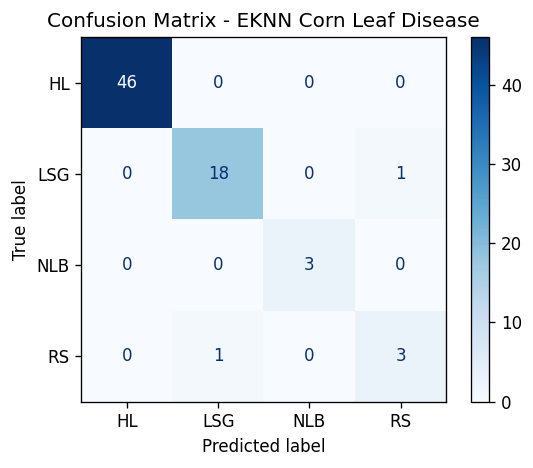

In [7]:

# ===================================================================================
# EVALUASI: CONFUSION MATRIX & CLASSIFICATION REPORT
# ===================================================================================

y_pred = eknn.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

labels_sorted = sorted(list(set(y)))
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix - EKNN Corn Leaf Disease")
plt.tight_layout()
plt.show()


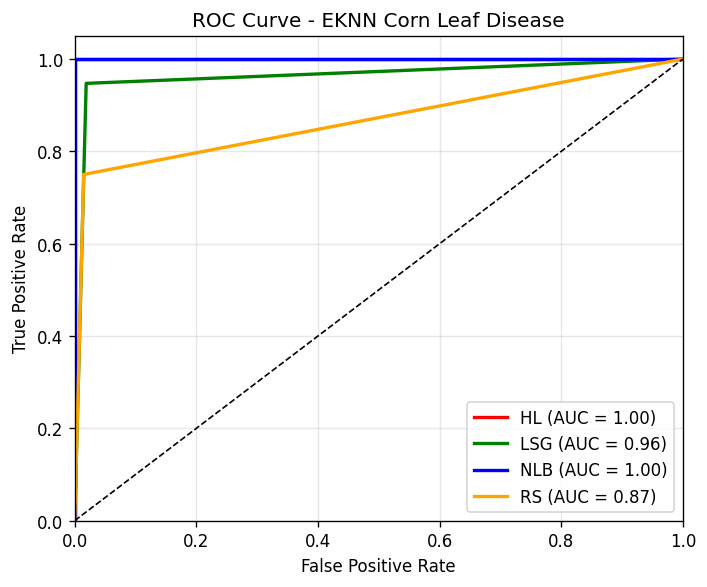

In [8]:

# ===================================================================================
# EVALUASI: ROC CURVE MULTI-KELAS
# ===================================================================================

classes = sorted(list(set(y)))
y_test_bin = label_binarize(y_test, classes=classes)
y_score_bin = label_binarize(y_pred, classes=classes)

plt.figure(figsize=(6, 5))
colors = cycle(["red", "green", "blue", "orange", "purple", "brown"])

for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - EKNN Corn Leaf Disease")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Contoh visualisasi before-after per kelas:

Kelas: daun sehat, contoh file: /content/dataset/data jagung/validation/daun sehat/(155)_result.jpg


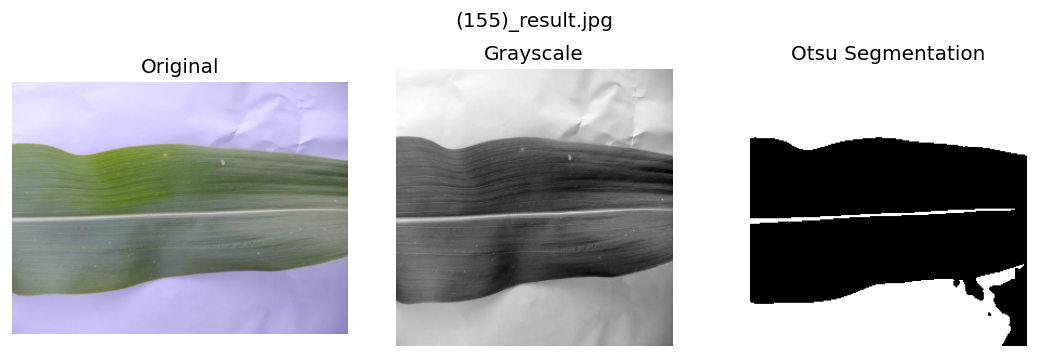

Kelas: hawar daun, contoh file: /content/dataset/data jagung/validation/hawar daun/1 (18)_result.jpg


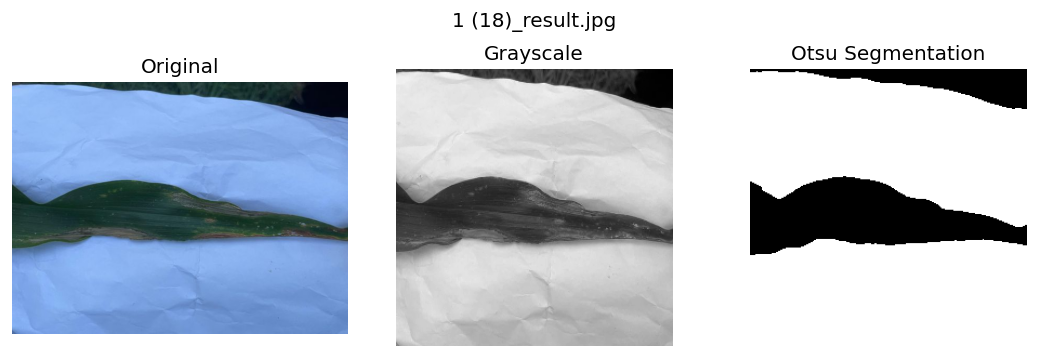

Kelas: karat daun, contoh file: /content/dataset/data jagung/validation/karat daun/1 (9)_result.jpg


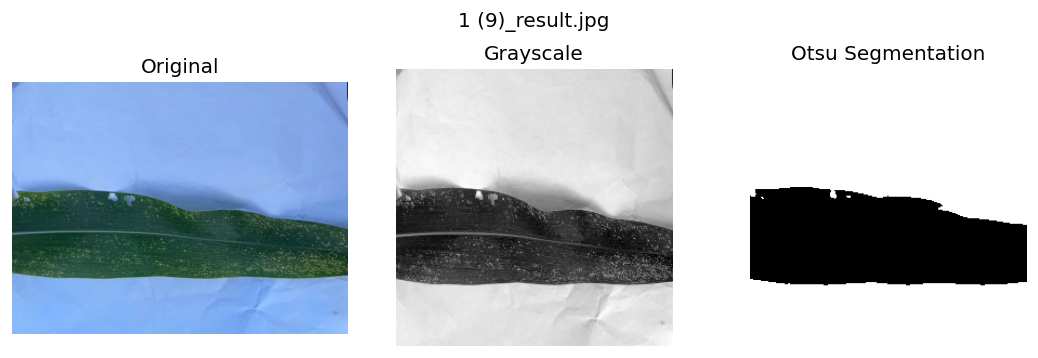

In [9]:

# ===================================================================================
# VISUALISASI: BEFORE–AFTER PREPROCESSING & OTSU SEGMENTATION
# ===================================================================================

import random

def show_before_after(path):
    """
    Menampilkan:
    - Citra asli (RGB)
    - Citra grayscale
    - Hasil segmentasi Otsu
    """
    img = cv2.imread(path)
    if img is None:
        print("Gagal membaca citra:", path)
        return

    rgb_norm, gray = preprocess_image(img)
    otsu_bin = segment_otsu(gray)

    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap="gray")
    plt.title("Grayscale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(otsu_bin, cmap="gray")
    plt.title("Otsu Segmentation")
    plt.axis("off")

    plt.suptitle(os.path.basename(path))
    plt.tight_layout()
    plt.show()


print("Contoh visualisasi before-after per kelas:\n")
for folder_name in CLASS_MAP.keys():
    folder_path = os.path.join(BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue
    files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not files:
        continue
    sample_path = os.path.join(folder_path, random.choice(files))
    print(f"Kelas: {folder_name}, contoh file: {sample_path}")
    show_before_after(sample_path)
